In [26]:
import random
import torch.nn as nn
import torch
import time
import math
import pickle
import pandas as pd
from pandas import Series, DataFrame
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score
import random
import pickle
from rdkit.Chem import rdchem, Lipinski
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromFASTA, MolToSmiles, MolFromSmiles
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch.optim as optim
folder = "/data/AIpep/"
import matplotlib.pyplot as plt
from Levenshtein import distance as lev_dist
from models import Classifier
from dataset import Dataset
from dataset import collate_fn_no_activity as collate_fn
import tmap as tm
from map4 import MAP4Calculator

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Plot properties

In [27]:
df_all = pd.read_pickle(folder+"pickles/DAASP_RNN_dataset_with_anticancer.plk")
df_anticancer = pd.read_pickle(folder+"pickles/gen_anticancer_with_NN_prop_helicity.pkl")

In [28]:
df_all_ = pd.concat([df_all,df_anticancer])

In [29]:
df_all = df_all_

In [30]:
gram_neg_training = df_all.query("Set == 'training' and activity == 1 and (baumannii == True or aeruginosa == True)")
gram_pos_training = df_all.query("Set == 'training' and activity == 1 and aureus == True")
gram_neg_test = df_all.query("Set == 'test' and activity == 1 and (baumannii == True or aeruginosa == True)")
gram_pos_test = df_all.query("Set == 'test' and activity == 1 and aureus == True")
gram_neg = df_all.query("Set == 'generated-TL-GN' and isPredActive == True")
gram_pos = df_all.query("Set == 'generated-TL-GP' and isPredActive == True")
gen = df_all.query("Set == 'generated' and isPredActive == True")
training_active = df_all.query("Set == 'training' and activity == 1")
test_active = df_all.query("Set == 'test' and activity == 1")
training_inactive = df_all.query("Set == 'training' and activity == 0")
test_inactive = df_all.query("Set == 'test' and activity == 0")
df_anticancer_training = df_all.query("Set == 'training' and activity == 1 and HeLa == True")
df_anticancer_test = df_all.query("Set == 'test' and activity == 1 and HeLa == True")
anticancer = df_all.query("Set == 'generated-TL-anticancer' and isPredActive == True")

In [31]:
len(anticancer)

11458

### Plot NN

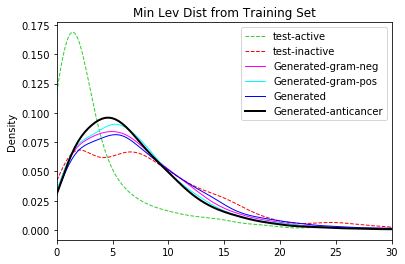

In [34]:
#training_active.dist_Training.plot.kde(label="training-active", c="limegreen", linewidth=1)
test_active.dist_Training.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
#training_inactive.dist_Training.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.dist_Training.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.dist_Training.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.dist_Training.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.dist_Training.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.dist_Training.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
plt.xlim(-0.01, 30)
plt.title("Min Lev Dist from Training Set")
plt.legend()

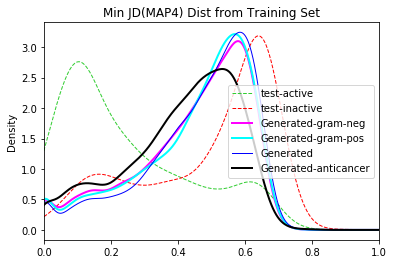

In [36]:
#training_active.map_dist_Training.plot.kde(label="training-active", c="limegreen", linewidth=1)
test_active.map_dist_Training.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
#training_inactive.map_dist_Training.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.map_dist_Training.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.map_dist_Training.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.map_dist_Training.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.map_dist_Training.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.map_dist_Training.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
plt.xlim(0,1)
plt.title("Min JD(MAP4) Dist from Training Set")
plt.legend()

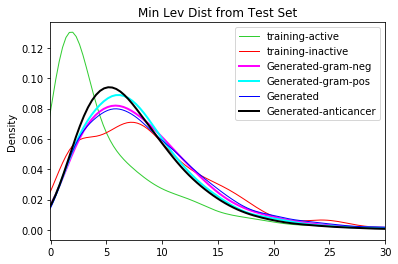

In [37]:
training_active.dist_Test.plot.kde(label="training-active", c="limegreen", linewidth=1)
#test_active.dist_Test.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.dist_Test.plot.kde(label="training-inactive", c="red", linewidth=1)
#test_inactive.dist_Test.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.dist_Test.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.dist_Test.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.dist_Test.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.dist_Test.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
plt.xlim(-0.01, 30)
plt.title("Min Lev Dist from Test Set")
plt.legend()

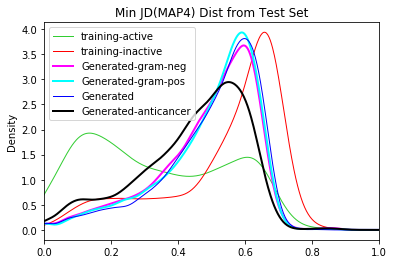

In [38]:
training_active.map_dist_Test.plot.kde(label="training-active", c="limegreen", linewidth=1)
#test_active.map_dist_Test.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.map_dist_Test.plot.kde(label="training-inactive", c="red", linewidth=1)
#test_inactive.map_dist_Test.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.map_dist_Test.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.map_dist_Test.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.map_dist_Test.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.map_dist_Test.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
plt.xlim(0,1)
plt.title("Min JD(MAP4) Dist from Test Set")
plt.legend()

### Plot properties

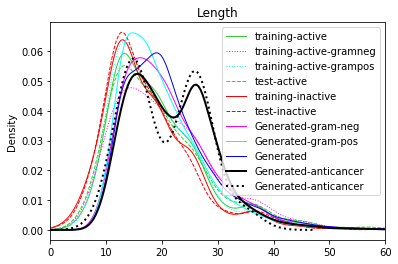

In [44]:
training_active.length.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.length.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.length.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.length.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.length.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.length.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.length.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.length.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.length.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.length.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.length.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.title("Length")
plt.xlim(0, 60)
plt.legend()

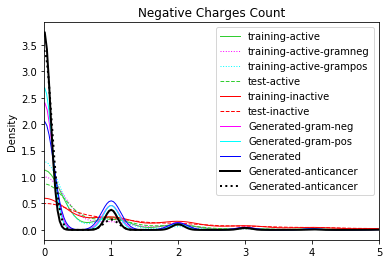

In [43]:
training_active.negative.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.negative.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.negative.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.negative.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.negative.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.negative.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.negative.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.negative.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.negative.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.negative.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.negative.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.title("Negative Charges Count")
plt.xlim(0, 5)
plt.legend()

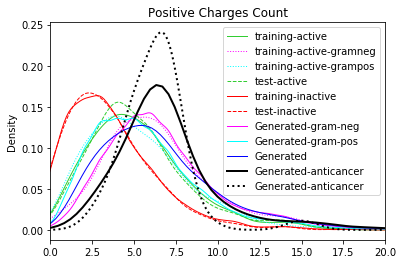

In [45]:
training_active.positive.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.positive.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.positive.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.positive.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.positive.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.positive.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.positive.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.positive.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.positive.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.positive.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.positive.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.xlim(0, 20)
plt.title("Positive Charges Count")
plt.legend()

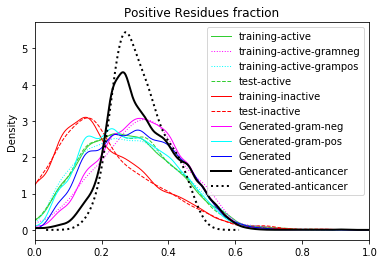

In [46]:
training_active.pos_res_fract.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.pos_res_fract.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.pos_res_fract.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.pos_res_fract.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.pos_res_fract.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.pos_res_fract.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.pos_res_fract.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.pos_res_fract.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.pos_res_fract.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.pos_res_fract.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.pos_res_fract.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.xlim(0, 1)
plt.title("Positive Residues fraction")
plt.legend()

Text(0.5, 1.0, 'Positive residues fraction')

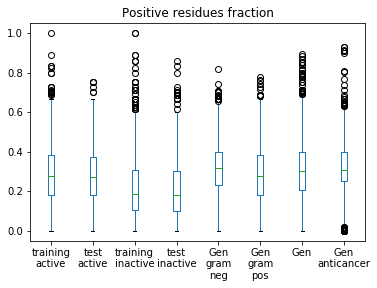

In [47]:
ax = training_active.pos_res_fract.plot.box(positions = [1])
ax = test_active.pos_res_fract.plot.box(ax=ax, positions = [2])
ax = training_inactive.pos_res_fract.plot.box(ax=ax, positions = [3])
ax = test_inactive.pos_res_fract.plot.box(ax=ax, positions = [4])
ax = gram_neg.pos_res_fract.plot.box(ax=ax, positions = [5])
ax = gram_pos.pos_res_fract.plot.box(ax=ax, positions = [6])
ax = gen.pos_res_fract.plot.box(ax=ax, positions = [7])
ax = anticancer.pos_res_fract.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Positive residues fraction")

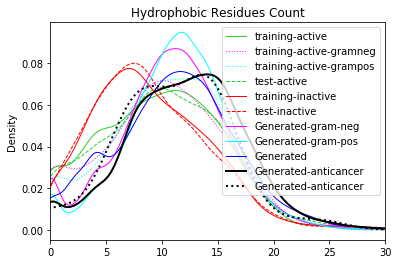

In [48]:
training_active.hydrophobic.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.hydrophobic.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.hydrophobic.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.hydrophobic.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.hydrophobic.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.hydrophobic.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.hydrophobic.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.hydrophobic.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.hydrophobic.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.hydrophobic.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.hydrophobic.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.xlim(0, 30)
plt.title("Hydrophobic Residues Count")
plt.legend()

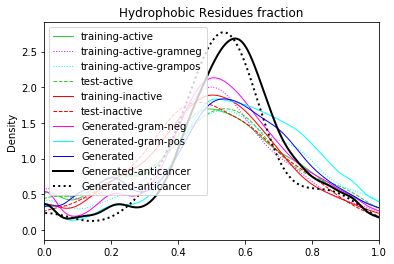

In [49]:
training_active.hydro_res_fract.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.hydro_res_fract.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.hydro_res_fract.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.hydro_res_fract.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.hydro_res_fract.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.hydro_res_fract.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.hydro_res_fract.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.hydro_res_fract.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.hydro_res_fract.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.hydro_res_fract.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.hydro_res_fract.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.xlim(0, 1)
plt.title("Hydrophobic Residues fraction")
plt.legend()

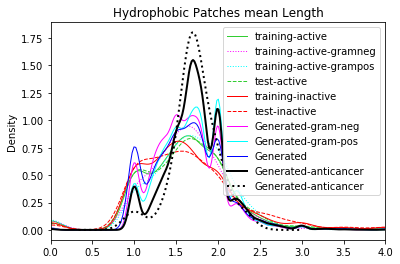

In [50]:
training_active.hydrophobic_patches_len.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.hydrophobic_patches_len.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.hydrophobic_patches_len.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.hydrophobic_patches_len.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.hydrophobic_patches_len.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.hydrophobic_patches_len.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.hydrophobic_patches_len.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.hydrophobic_patches_len.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.hydrophobic_patches_len.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.hydrophobic_patches_len.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.hydrophobic_patches_len.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.xlim(0, 4)
plt.title("Hydrophobic Patches mean Length")
plt.legend()

Text(0.5, 1.0, 'Hydrophobic Patches mean Length')

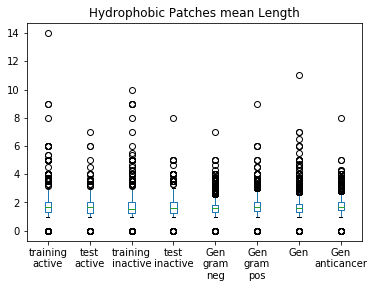

In [51]:
ax = training_active.hydrophobic_patches_len.plot.box(positions = [1])
ax = test_active.hydrophobic_patches_len.plot.box(ax=ax, positions = [2])
ax = training_inactive.hydrophobic_patches_len.plot.box(ax=ax, positions = [3])
ax = test_inactive.hydrophobic_patches_len.plot.box(ax=ax, positions = [4])
ax = gram_neg.hydrophobic_patches_len.plot.box(ax=ax, positions = [5])
ax = gram_pos.hydrophobic_patches_len.plot.box(ax=ax, positions = [6])
ax = gen.hydrophobic_patches_len.plot.box(ax=ax, positions = [7])
ax = anticancer.hydrophobic_patches_len.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Hydrophobic Patches mean Length")

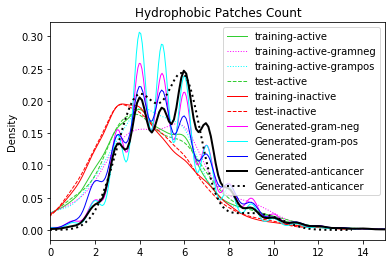

In [54]:
training_active.hydrophobic_patches_num.plot.kde(label="training-active", c="limegreen", linewidth=1)
gram_neg_training.hydrophobic_patches_num.plot.kde(label="training-active-gramneg", c="magenta", linewidth=1, linestyle=":")
gram_pos_training.hydrophobic_patches_num.plot.kde(label="training-active-grampos", c="cyan", linewidth=1, linestyle=":")
test_active.hydrophobic_patches_num.plot.kde(label="test-active", c="limegreen", linestyle="--", linewidth=1)
training_inactive.hydrophobic_patches_num.plot.kde(label="training-inactive", c="red", linewidth=1)
test_inactive.hydrophobic_patches_num.plot.kde(label="test-inactive", c="red", linestyle="--", linewidth=1)
gram_neg.hydrophobic_patches_num.plot.kde(label="Generated-gram-neg", c="magenta", linewidth=1)
gram_pos.hydrophobic_patches_num.plot.kde(label="Generated-gram-pos", c="cyan", linewidth=1)
gen.hydrophobic_patches_num.plot.kde(label="Generated", c="blue", linewidth=1)
anticancer.hydrophobic_patches_num.plot.kde(label="Generated-anticancer", c="black", linewidth=2)
df_anticancer_training.hydrophobic_patches_num.plot.kde(label="Generated-anticancer", c="black", linewidth=2, linestyle=":")
plt.xlim(0, 15)
plt.title("Hydrophobic Patches Count")
plt.legend()

Text(0.5, 1.0, 'Hydrophobic Patches Count')

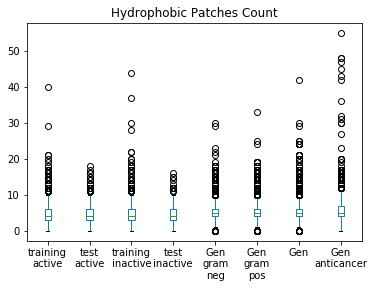

In [52]:
ax = training_active.hydrophobic_patches_num.plot.box(positions = [1])
ax = test_active.hydrophobic_patches_num.plot.box(ax=ax, positions = [2])
ax = training_inactive.hydrophobic_patches_num.plot.box(ax=ax, positions = [3])
ax = test_inactive.hydrophobic_patches_num.plot.box(ax=ax, positions = [4])
ax = gram_neg.hydrophobic_patches_num.plot.box(ax=ax, positions = [5])
ax = gram_pos.hydrophobic_patches_num.plot.box(ax=ax, positions = [6])
ax = gen.hydrophobic_patches_num.plot.box(ax=ax, positions = [7])
ax = anticancer.hydrophobic_patches_num.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Hydrophobic Patches Count")

Text(0.5, 1.0, 'Hydrophobic Moment')

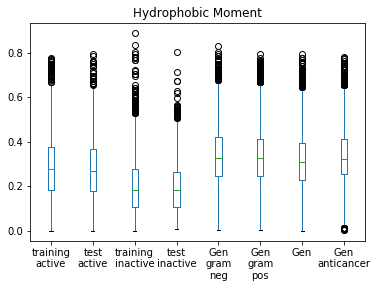

In [53]:
ax = training_active.HydroMoment.plot.box(positions = [1])
ax = test_active.HydroMoment.plot.box(ax=ax, positions = [2])
ax = training_inactive.HydroMoment.plot.box(ax=ax, positions = [3])
ax = test_inactive.HydroMoment.plot.box(ax=ax, positions = [4])
ax = gram_neg.HydroMoment.plot.box(ax=ax, positions = [5])
ax = gram_pos.HydroMoment.plot.box(ax=ax, positions = [6])
ax = gen.HydroMoment.plot.box(ax=ax, positions = [7])
ax = anticancer.HydroMoment.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Hydrophobic Moment")

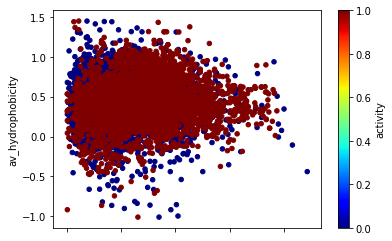

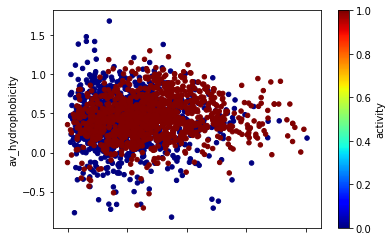

In [55]:
df_all.query("Set == 'training'").plot.scatter(x="HydroMoment", y="av_hydrophobicity", c ="activity", colormap="jet")
df_all.query("Set == 'test'").plot.scatter(x="HydroMoment", y="av_hydrophobicity", c ="activity", colormap="jet")

Text(0.5, 1.0, 'Predicted Fraction Helical')

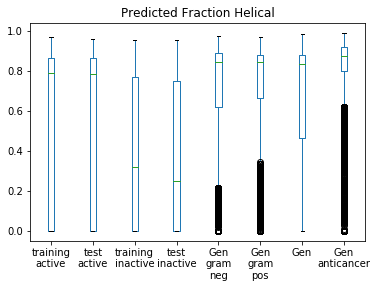

In [56]:
ax = training_active.fraction_PredHelical.plot.box(positions = [1])
ax = test_active.fraction_PredHelical.plot.box(ax=ax, positions = [2])
ax = training_inactive.fraction_PredHelical.plot.box(ax=ax, positions = [3])
ax = test_inactive.fraction_PredHelical.plot.box(ax=ax, positions = [4])
ax = gram_neg.fraction_PredHelical.plot.box(ax=ax, positions = [5])
ax = gram_pos.fraction_PredHelical.plot.box(ax=ax, positions = [6])
ax = gen.fraction_PredHelical.plot.box(ax=ax, positions = [7])
ax = anticancer.fraction_PredHelical.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Predicted Fraction Helical")

Text(0.5, 1.0, 'Predicted Fraction Beta Sheet')

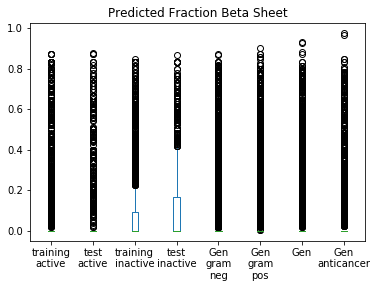

In [57]:
ax = training_active.fraction_PredBetaSheet.plot.box(positions = [1])
ax = test_active.fraction_PredBetaSheet.plot.box(ax=ax, positions = [2])
ax = training_inactive.fraction_PredBetaSheet.plot.box(ax=ax, positions = [3])
ax = test_inactive.fraction_PredBetaSheet.plot.box(ax=ax, positions = [4])
ax = gram_neg.fraction_PredBetaSheet.plot.box(ax=ax, positions = [5])
ax = gram_pos.fraction_PredBetaSheet.plot.box(ax=ax, positions = [6])
ax = gen.fraction_PredBetaSheet.plot.box(ax=ax, positions = [7])
ax = anticancer.fraction_PredBetaSheet.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Predicted Fraction Beta Sheet")

Text(0.5, 1.0, 'Predicted Fraction Coil')

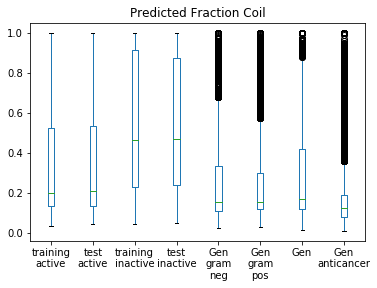

In [58]:
ax = training_active.fraction_PredCoil.plot.box(positions = [1])
ax = test_active.fraction_PredCoil.plot.box(ax=ax, positions = [2])
ax = training_inactive.fraction_PredCoil.plot.box(ax=ax, positions = [3])
ax = test_inactive.fraction_PredCoil.plot.box(ax=ax, positions = [4])
ax = gram_neg.fraction_PredCoil.plot.box(ax=ax, positions = [5])
ax = gram_pos.fraction_PredCoil.plot.box(ax=ax, positions = [6])
ax = gen.fraction_PredCoil.plot.box(ax=ax, positions = [7])
ax = anticancer.fraction_PredCoil.plot.box(ax=ax, positions = [8])
ax.set_xticklabels(["training\nactive","test\nactive","training\ninactive","test\ninactive", "Gen\ngram\nneg", "Gen\ngram\npos", "Gen", "Gen\nanticancer"])
plt.title("Predicted Fraction Coil")

### TMAP

In [59]:
active = df_all.query("activity == 1")
inactive = df_all.query("activity == 0")
gen_gramneg = df_all.query("Set == 'generated-TL-GN' and isPredActive == True")
gen_grampos = df_all.query("Set == 'generated-TL-GP' and isPredActive == True")

import tmap as tm
from faerun import Faerun
from scipy.stats import rankdata
from matplotlib.colors import ListedColormap

fps_ = []

fps1 = active["MAP4"].tolist()
fps2 = inactive["MAP4"].tolist()    
fps3 = anticancer["MAP4"].tolist()

for fps in  [fps1, fps2, fps3]:
    for fp in fps:
        fp_ = tm.VectorUint(fp)
        fps_.append(fp_)

    
lf = tm.LSHForest(1024, 32)
lf.batch_add(fps_)

lf.index()

lf.store(folder + 'ML_Peptides_LSHforest')

#lf = tm.LSHForest(1024, 32)
#lf.restore(folder + 'ML_Peptides_LSHforest')

CFG_TMAP = tm.LayoutConfiguration()

HAC1 = active.HAC.tolist()
HAC2 = inactive.HAC.tolist()
HAC3 = anticancer.HAC.tolist()

HAC = HAC1 + HAC2 + HAC3
HAC_r = rankdata(HAC)

HE1 = active.fraction_PredHelical.tolist()
HE2 = inactive.fraction_PredHelical.tolist()
HE3 = anticancer.fraction_PredHelical.tolist()

HE = HE1 + HE2 + HE3
HE_r = rankdata(HE)

HM1 = active.HydroMoment.tolist()
HM2 = inactive.HydroMoment.tolist()
HM3 = anticancer.HydroMoment.tolist()

HM = HM1 + HM2 + HM3
HM_r = rankdata(HM)

seq1 = active.Sequence.tolist()
seq2 = inactive.Sequence.tolist()
seq3 = anticancer.Sequence.tolist()

seq = seq1 + seq2 + seq3

fromset = [0]*len(active) + [1]*len(inactive) + [2]*len(anticancer)

# config
CFG_TMAP.k = 50
CFG_TMAP.kc = 50
CFG_TMAP.sl_scaling_min = 1.0
CFG_TMAP.sl_scaling_max = 1.0
CFG_TMAP.sl_repeats = 1
CFG_TMAP.sl_extra_scaling_steps = 2
CFG_TMAP.placer = tm.Placer.Barycenter
CFG_TMAP.merger = tm.Merger.LocalBiconnected
CFG_TMAP.merger_factor = 2.0
CFG_TMAP.merger_adjustment = 0
CFG_TMAP.fme_iterations = 1000
CFG_TMAP.sl_scaling_type = tm.ScalingType.RelativeToDesiredLength
CFG_TMAP.node_size = 1 / 40
CFG_TMAP.mmm_repeats = 1

# Compute the layout
x, y, s, t, gp = tm.layout_from_lsh_forest(lf, config=CFG_TMAP)

custom_cmap = ListedColormap([ "limegreen", "tomato", "cyan"], name="custom")

groups = ["0-Active", '1-Inactive', '2-Sampled-TL-anticancer']
labels_groups, groups = Faerun.create_categories(groups)


# faerun plot
faerun = Faerun(view="front", coords=False, title='Peptide-RNN-TL')#, clear_color="#ffffff",)
faerun.add_scatter("PMC",{"x": x, "y": y, "c": [HAC_r, HE, HM, fromset], "labels": seq}, has_legend=True, \
    colormap=["rainbow", "rainbow", "rainbow", custom_cmap], \
        point_scale=2.5, categorical=[False, False, False, True],\
        series_title=["Heavy Atom Count", "Predicted Helicity", "Hydrophobic Moment", "Set"], \
            max_legend_label=[str(round(max(HAC),2)), str(round(max(HE),2)), str(round(max(HM),2)), None],\
                   min_legend_label=[str(round(min(HAC),2)), str(round(min(HE),2)), str(round(min(HM),2)), None],\
                    legend_labels=[None, None, None, labels_groups])



faerun.add_tree("PMC_tree",{"from": s, "to": t}, point_helper="PMC", color="aaaaaa")
faerun.plot('Peptide-RNN-TL')#, template = 'smiles')

/home/alice/Code/AIpep/anticancers/Peptide-RNN-TL.html